# Kernel SHAP explanation for multinomial logistic regression models 

## Introduction

In a previous [example](kernel_shap_wine_intro.ipynb), we showed how the KernelSHAP algorithm can be aplied to explain the output of an arbitrary classification model so long the model outputs probabilities or operates in margin space. We also showcased the powerful visualisations in the `shap` library that can be used for model investigation. In this example we focus on understanding, in a simple setting, how conclusions drawn from the analysis of the KernelShap output relate to conclusions drawn from interpreting the model directly. To make this possible, we fit a logistic regression model on the Wine dataset.

In [1]:
import shap
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)  # suppress deprecation messages
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from alibi.explainers.kernel_shap import KernelShap
from scipy.special import logit
from sklearn.datasets import load_wine
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
shap.initjs()

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood a

## Data preparation: load and split Wine dataset

In [2]:
wine = load_wine()
wine.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names'])

In [3]:
data = wine.data
target = wine.target
target_names = wine.target_names
feature_names  = wine.feature_names

Split data into testing and training sets and normalize it.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data, 
                                                    target, 
                                                    test_size=0.2, 
                                                    random_state=0,
                                                   )
print("Training records: {}".format(X_train.shape[0]))
print("Testing records: {}".format(X_test.shape[0]))

Training records: 142
Testing records: 36


In [5]:
scaler = StandardScaler().fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

## Fitting a multinomial logistic regression classifier to the Wine dataset

### Training 

In [6]:
classifier = LogisticRegression(multi_class='multinomial',
                                random_state=0,
                                )
classifier.fit(X_train_norm, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Model assessment

Look at at average $10$-fold cross validation accuracy and 

In [7]:
y_pred = classifier.predict(X_test_norm)

In [8]:
cm = confusion_matrix(y_test, y_pred)

Text(0.5, 1.0, 'Confusion matrix for the logistic regression classifier')

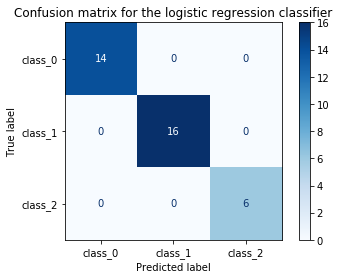

In [9]:
title = 'Confusion matrix for the logistic regression classifier'
disp = plot_confusion_matrix(classifier, 
                             X_test_norm, 
                             y_test,
                             display_labels=target_names,
                             cmap=plt.cm.Blues,
                             normalize=None,
                            )
disp.ax_.set_title(title)

## Intepreting the logistic regression model

<a id='src_2'></a>
One way to arrive at the multinomial logistic regression model is to consider modelling a categorical response 
variable $y \sim \text{Cat} (y| \beta x)$ where $\beta$ is $K \times D$ matrix of distribution parameters with $K$ being the number of classes and $D$ the feature dimensionality. Because the probability of outcome $k$ being observed given $x$, $p_{k} = p(y=k|x, \mathbf{\beta})$, is bounded by $[0, 1]$, the logistic regression assumes that a linear relationship exists between the *logit* transformation of the output and the input. This can be formalised as follows:

<h3 align="center"> $ \log \left( \frac{p_{k}}{1 - p_{k}} \right) = \beta_{0,k} + \beta_{1,k} x_{1}  + \beta_{2,k} x_{2} + \cdots + \beta_{D,k} x_{D} = \mathbf{\beta}_k \cdot x $  </h3>.

Note that the RHS is a function of a random variable mean, which is sometimes referred to as a *link function* in the literature. The coefficients $\beta$ of the linear relations used to fit the logit transformation are estimated jointly given a set of training examples $\mathcal{D}=  \{(x_i, y_i)\}_{i=1}^N$. 

For each class, the vector of coefficients $\mathbb{\beta}_k$ can be used to interpret the model *globally*; in the absence of interaction terms, the coefficient of a predictor (i.e.,  independent variable) represents the *change in log odds* when the predictor changes by one unit while all other variables are kept at fixed values. Equivalently, the exponentiated coefficient is equivalent to a change in odds. Since the transformation from odds to outcome probabilities is monotonic, a change in odds also implies a change in the outcome probability in the same direction. Thus, the magnitudes of the feature coefficients measure the effect of a predictor on the output and thus one can globally interpret the logistic regression model.

However, the log odds ratios and odds ratios are known to be sensitive to *unobserved heterogenity*, that is, omission of a variable with good explanatory power from a logistic regression model *assumed true*. While we will not be concerned directly with this issue and refer the interested reader to [[2]](#ref_1), we will be using the *estimated percentage unit effect* (or the *marginal effect*)

<h3 align="center"> $\beta_{j,k} \times p_{i,k}(1 - p_{i, k})$</h3>

as a means of estimating the effect of a predictor $j$ on individual $i$ ($x_{i, j})$ with respect to predicting the $k^{th}$ class and thus *locally* interpret the model. The average marginal effect is more robust measure of effects in situations where effects are compared across different groups or models. Consider a logistic model where an independent variable $x_1$ is used to predict an outcome and a logistic model where $x_2$, known to be uncorrelated with $x_1$, is also included. Since the two models assign different probabilities to the different outcomes and since the distribution of the outcome across values of $x_1$ should be the same across the two models (due to the independence assumption), we expected the second model will scale the coeffcient of $\beta_1$. Hence, the log-odds and odds ratios are not robust to unobserved heterogeneity so directly comparing the two across models or groups can be misleading. As discussed in [[2]](#ref_1), the marginal effect is generally robust to the effect.


The average marginal effect (AME) of a predictor

<h3 align="center"> $\frac{1}{n} \sum_{i=1}^{n}\beta_{j,k} \times p_{i,k} (1 - p_{i,k})$</h3>

is equivalent to simply using $\beta_{j,k}$ to *globally* explain the model.

In [10]:
def issorted(arr, reverse=False):
    """
    Checks if a numpy array is sorted.
    """
    
    if reverse:
        return np.all(arr[::-1][:-1] <=arr[::-1][1:])
    
    return np.all(arr[:-1] <= arr[1:])

def extract_importances(class_idx, beta, feature_names, intercepts=None):
    """
    Retrive and sort abs magnitude of coefficients from model.
    """
    
    # sort the absolute value of model coef from largest to smallest
    srt_beta_k = np.argsort(np.abs(beta[class_idx, :]))[::-1]
    feat_names = [feature_names[idx] for idx in srt_beta_k]
    feat_imp = beta[class_idx, srt_beta_k]
    
    # include bias among feat importances 
    if intercepts is not None: 
        intercept = intercepts[class_idx]
        bias_idx = len(feat_imp) - (np.searchsorted(np.abs(feat_imp)[::-1], np.abs(intercept)))
#         bias_idx = np.searchsorted(np.abs(feat_imp)[::-1], np.abs(intercept)) + 1
        feat_imp = np.insert(feat_imp, bias_idx, intercept.item(), )
        intercept_idx = np.where(feat_imp == intercept)[0][0]
        feat_names.insert(intercept_idx, 'bias')

    return feat_imp, feat_names

def plot_importances(feat_imp, feat_names, **kwargs):
    """
    Create a horizontal barchart of feature effects, sorted by their magnitude.
    """
    
    left_x, right_x = kwargs.get("left_x"), kwargs.get("right_x")
    eps_factor = kwargs.get("eps_factor", 4.5)
    xlabel = kwargs.get("xlabel", None)
    ylabel = kwargs.get("ylabel", None)
    labels_fontsize = kwargs.get("labels_fontsize", 15)
    tick_labels_fontsize = kwargs.get("tick_labels_fontsize", 15)
    
    # plot
    fig, ax = plt.subplots(figsize=(10, 5))
    y_pos = np.arange(len(feat_imp))
    ax.barh(y_pos, feat_imp)
    
    # set lables
    ax.set_yticks(y_pos)
    ax.set_yticklabels(feat_names, fontsize=tick_labels_fontsize)
    ax.invert_yaxis()                  # labels read top-to-bottom
    ax.set_xlabel(xlabel, fontsize=labels_fontsize)
    ax.set_ylabel(ylabel, fontsize=labels_fontsize)
    ax.set_xlim(left=left_x, right=right_x)
    
    # add text
    for i, v in enumerate(feat_imp):
        eps = 0.03
        if v < 0:
            eps = -eps_factor*eps
        ax.text(v + eps, i + .25, str(round(v, 3)))
    
    return ax, fig

We now retrieve the estimate coefficients, and plot them sorted by their maginitude.

In [11]:
beta = classifier.coef_
intercepts = classifier.intercept_
all_coefs = np.concatenate((beta, intercepts[:, None]), axis=1)

In [12]:
class_idx = 0
feat_imp, feat_names = extract_importances(class_idx, 
                                           beta, 
                                           feature_names,
                                          )

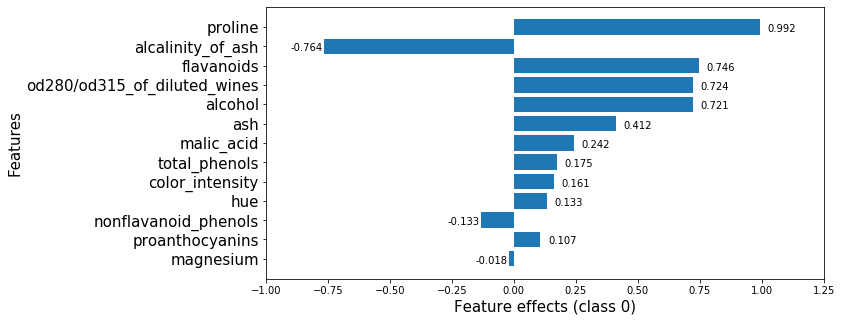

In [13]:
_, class_0_fig = plot_importances(feat_imp, 
                                  feat_names, 
                                  left_x=-1.,
                                  right_x=1.25,
                                  xlabel = "Feature effects (class {})".format(class_idx),
                                  ylabel = "Features"
                                  )

Note that these effects are with respect to the model bias (displayed below).

In [14]:
classifier.intercept_

array([ 0.24013981,  0.66712652, -0.90726633])

This plot shows that features such as `proline`, `flavanoids`, `od280/od315_of_diluted_wines`, `alcohol` increase the odds of *any* sample being classified as `class_0` whereas the `alcalinity_of_ash` decreases them.

In [15]:
feat_imp, feat_names = extract_importances(1,            # class_idx 
                                           beta, 
                                           feature_names,
                                          )

The plot below shows that, however, `alcalinity_of_ash` increases the odds of a wine being in `class_1`. Predictors such as `proline`, `alcohol` or `ash`, which increase the odds of predicting a wine as a member of `class_0`, decrease the odds of predicting it as a member of `class_1`.

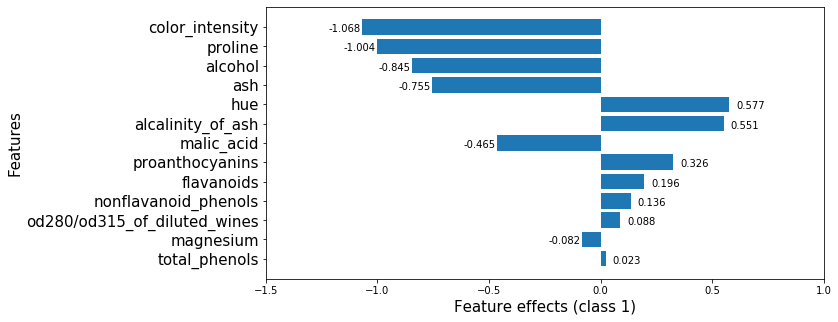

In [16]:
_, class_1_fig = plot_importances(feat_imp, 
                                  feat_names, 
                                  left_x=-1.5,
                                  right_x=1,
                                  eps_factor = 5,  # controls text distance from end of bar for negative examples
                                  xlabel = "Feature effects (class {})".format(1),
                                  ylabel = "Features"
                                  )

In [17]:
feat_imp, feat_names = extract_importances(2, # class_idx
                                           beta, 
                                           feature_names,
                                          )

Finally, for `class_2`, the `color_intensity`, `ash` are the features that increase the `class_2` odds.

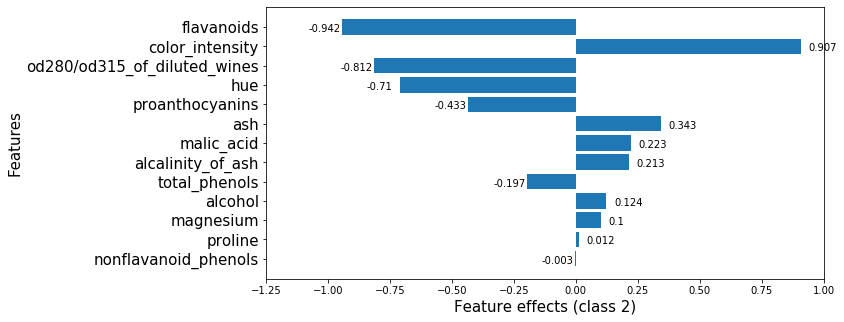

In [18]:
_, class_2_fig = plot_importances(feat_imp, 
                                  feat_names, 
                                  left_x=-1.25,
                                  right_x=1,
                                  xlabel = "Feature effects (class {})".format(2),
                                  ylabel = "Features"
#                                   eps_factor = 5.
                                  )

## Apply KernelSHAP to explain the model

<a id='src_1'></a>
Note that the *local accuracy* property of SHAP (eq. (5) in [[1]](#ref_1))  requires
<h3 align='center'> $f(x) = g(x') = \phi_0 + \sum_{j=1}^D \phi_j x_j'.$</h3>

Hence, sum of the feature importances, $\phi_j$, should be equal to the model output, $f(x)$. By passing `link='logit'` to the explainer, we ensure that $\phi_0$, the *base value* (see _**Local explanation**_ section [here](kernel_shap_wine_intro.ipynb)) will be calculated in the correct units. Note that here $x' \in \mathbb{R}^D$ represents a *simplified input* for which the shap value is computed. A simple example of a simplified input in the image domain, justified by the dimensionality of the input space, is a *superpixel mask*: we formulate the task of explaining the outcome of an image prediction task as determining the effects of each superpixel in a segmenented image upon the outcome. The interested reader is referred to [[1]](#ref_1) for more details about simplified inputs.

In [19]:
pred_fcn = classifier.predict_proba
lr_explainer = KernelShap(pred_fcn, link='logit')
lr_explainer.fit(X_train_norm)

Using 142 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [20]:
# passing the logit link function to the explainer ensures the units are consistent ...
mean_scores_train = logit(pred_fcn(X_train_norm).mean(axis=0))
print(mean_scores_train - lr_explainer.expected_value)  

[-6.66133815e-16  0.00000000e+00  4.44089210e-16]


In [21]:
lr_explanation = lr_explainer.explain(X_test_norm, l1_reg=False)

Because the dimensionality of the feature space is relatively small, we opted not to regularise the regression that computes the Shapley values. For more information about the regularisation options available for higher dimensional data see the introductory example [here](kernel_shap_wine_intro.ipynb).

### Locally explaining multi-output models with KernelShap

### Explaining the logitstic regression model globally with KernelSHAP

#### Summary plots

To visualise the impact of the features on the decision scores associated with class `class_idx`, we can use a summary plot. In this plot, the features are sorted by the sum of their SHAP values magnitudes across all instances in `X_test_norm`. Therefore, the features with the highest impact on the decision score for class `class_idx` are displayed at the top of the plot.

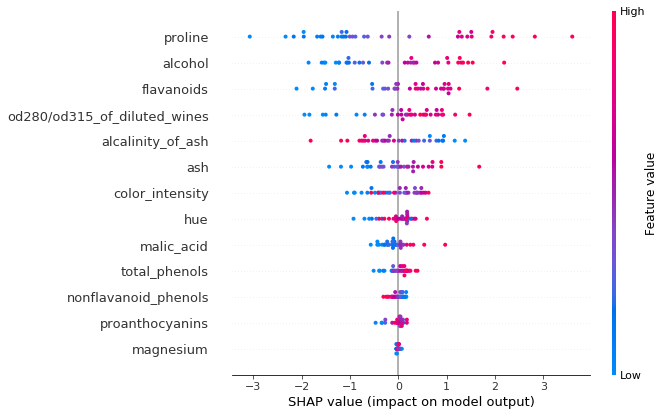

In [22]:
shap.summary_plot(lr_explanation.shap_values[class_idx], X_test_norm, feature_names)

Because the logistic regression model uses a linear predictor function, the exact shap values for each class $k$ can be computed exactly according to ([[1]](#ref_1))
<h3 align="center">$ \phi_{i,j}(f, x_i) = \beta_{j,k}(x_{i,j} - \mathbb{E}_{\mathcal{D}}[x_{j}]).$</h3>

Here we introduced an additional index $i$ to emphasize that we compute a shap value for *each predictor* and *each instance* in a set to be explained.This allows us to check the accuracy of the SHAP estimate. Note that we have already applied the normalisation so the expectation is not subtracted below.


In [23]:
exact_shap = beta[:, None, :]*X_test_norm

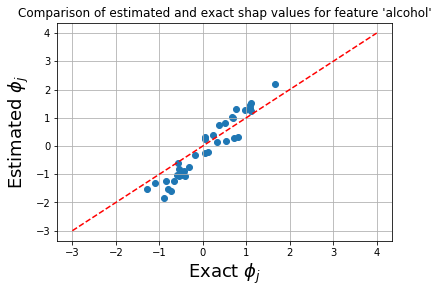

In [24]:
feat_name = 'alcohol'
feat_idx = feature_names.index(feat_name)
x = np.linspace(-3, 4, 1000)
plt.scatter(exact_shap[class_idx,...][:, feat_idx], lr_explanation.shap_values[class_idx][:, feat_idx])
plt.plot(x, x, linestyle='dashed', color='red')
plt.xlabel('Exact $\phi_j$', fontsize=18)
plt.ylabel('Estimated $\phi_j$', fontsize=18)
plt.title(r"Comparison of estimated and exact shap values for feature '{}'".format(feat_name))
plt.grid(True)

The plot below shows that the exact shap values and the estimate values give rise to similar ranking of the features, and only the order of the `flavanoids` and `alcohol`features is swapped.

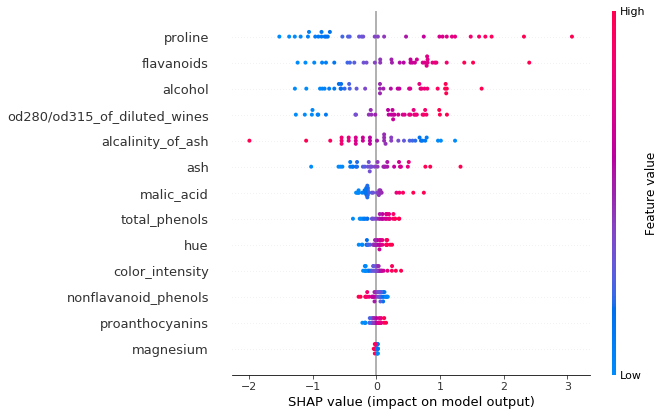

In [25]:
shap.summary_plot(exact_shap[class_idx, ...], X_test_norm, feature_names)

An simlar plot can be create for the logistic regression model by plotting the marginal effects. Note that the plot labelling cannot be changed, so the x axis is incorrectly labeled as `SHAP value` below.

In [26]:
p = classifier.predict_proba(X_test_norm)
prb = p * (1. - p) 
marg_effects = all_coefs[:, None, :] * prb.T[..., None]
assert (all_coefs[0, 0] * prb[:, 0] - marg_effects[0, :, 0]).sum() == 0.0
avg_marg_effects = np.mean(marg_effects, axis=1) # nb: ranking of the feature coefs should be preserved
mask = np.ones_like(X_test_norm)  # the effect (postive vs negative) on the output depend on the sign of the input
mask[X_test_norm < 0] = -1

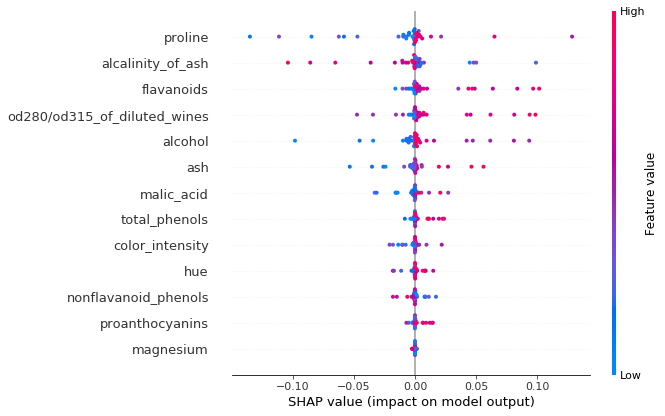

In [27]:
shap.summary_plot(marg_effects[class_idx, :, :-1]*mask, X_test_norm, feature_names)  # exclude bias

As expected, the ranking of the marginal effects is the same as that provided the ranking the raw coefficients (see below). However, this effect measure allows us to assess the effects at instance level. Note that both the approximate computation and the exact method yield the same group of features as the most important, although their rankings are not identical. It is important to note that the exact effects ranking and absolute values is a function of the entire data (due to the dependence of the model coefficients) whereas the approximate computation is *local*: the explanation model is fitted locally around each instance. We also notice that the approximate and exact shap value computation both identify the same relationship between the feature value and the effect on the evidence of a sample belonging to `class_idx`. 

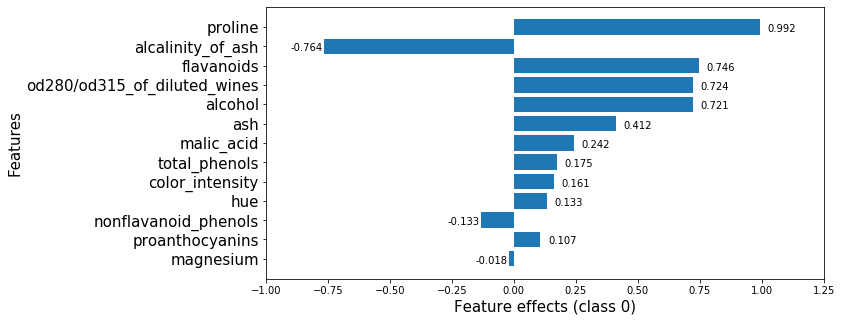

In [28]:
class_0_fig

Looking at the 6 most important features for this classification in `class_0`, we see that both the `KernelSHAP` method and the logistic regression rank the `proline` feature as the one with the most significant effect. While the order of the subsequent 5 features is permuted, the effects of these features are also very similar so, in effect, similar conclusions would be drawn from analysing either output.

### References

<a id='ref_1'></a>
[1](#src_1) [1] Lundberg, S.M. and Lee, S.I., 2017. A unified approach to interpreting model predictions. In Advances in neural information processing systems (pp. 4765-4774).

[2](#src_2) [2]Mood, C., 2017. "Logistic regression: Uncovering unobserved heterogeneity."